In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')#TODO change helper.py file so inharmoniicity is from . and also change midi file so sharedtypes is in lib rather than midi folder
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [3]:
# Return hidden score states 
from librosa import hz_to_note
note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=True)
score, time_to_next, cumulative= dict_to_frequency_list(dic)
for i in score:
    print(hz_to_note(i))

['C4']
['C4' 'E4']
['C4' 'E4' 'G4']
['C5' 'C4' 'E4' 'G4']
['E4' 'C5' 'E5' 'C4' 'G4']
['E4' 'C5' 'G4' 'E5' 'C4']
['E4' 'C5' 'G4' 'E5' 'C4']
['E4' 'C5' 'E5' 'G4' 'C4']
['E4' 'C5' 'E5' 'G4' 'C4']
['C5' 'E5' 'G4' 'C4' 'E4']
['C5' 'E5' 'G4' 'C4' 'E4']
['E5' 'C5' 'G4' 'C4' 'E4']
['E5' 'C5' 'G4' 'C4' 'E4']
['G4' 'E5' 'C5' 'C4' 'E4']
['G4' 'E5' 'C5' 'C4' 'E4']
['E5' 'G4' 'C5' 'C4' 'E4']
['G4' 'E5' 'C5' 'C4']
['C5' 'E5' 'D4' 'C4']
['C4' 'E5' 'A4' 'D4']
['E5' 'A4' 'D4' 'C4' 'D5']
['A4' 'D4' 'F5' 'C4' 'D5']
['D4' 'F5' 'C4' 'A4' 'D5']
['D5' 'D4' 'F5' 'C4' 'A4']
['D5' 'D4' 'C4' 'A4' 'F5']
['D5' 'D4' 'C4' 'A4' 'F5']
['D5' 'D4' 'C4' 'A4' 'F5']
['D5' 'D4' 'A4' 'C4' 'F5']
['D5' 'D4' 'A4' 'C4' 'F5']
['D5' 'D4' 'A4' 'C4' 'F5']
['D5' 'A4' 'D4' 'C4' 'F5']
['D5' 'A4' 'D4' 'C4' 'F5']
['D5' 'A4' 'D4' 'C4' 'F5']
['D5' 'A4' 'D4' 'B3' 'F5']
['F5' 'D4' 'B3' 'D5']
['G4' 'D5' 'D4' 'B3' 'F5']
['G4' 'D4' 'B3' 'D5' 'F5']
['G4' 'F5' 'D4' 'B3' 'D5']
['F5' 'D4' 'B3' 'G4' 'D5']
['F5' 'D4' 'B3' 'G4' 'D5']
['D4' 'B3' 'F5' '

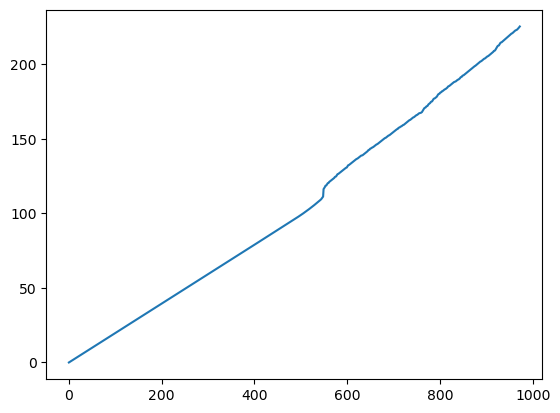

In [4]:
plt.plot(cumulative)



In [26]:
# Create cov_dict

cov_dict = {}
sample_length = 700
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=50
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:100]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

In [6]:
# Update: don't even need a transition matrix tbh!!!

# Note 
K = len(score[:130]) # The number of states, K
transition = np.full((K, K, max_d), -np.inf) 
for i in range(K-1): # Populate transition probabilities except final row
    transition[i][i][:], transition[i][i+1][:] = np.log(0.5), np.log(0.5)
transition[-1][-1][:] = np.log(1) # Update final row so transition probability is one, to itself

In [7]:
print(transition[2,4,7])

-inf


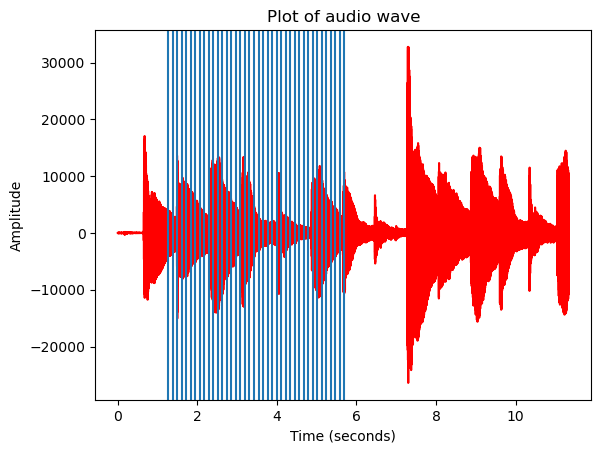

In [27]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 5000

show = 500000
offset = 56000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/slow_sustain.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [9]:
p = 1/2.9
q = 1 - p
d = 4
advance_transition = np.sum([q**i * p for i in range(d)])
print(advance_transition)

0.8157436718927837


whole lml values:  -327347675581.83105 2.6750843881722207e+20 45670578105.67212


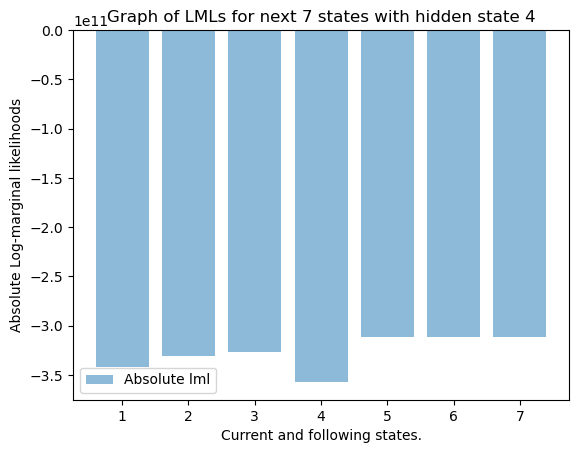

[-3.77322609 -3.7668159  -3.76442043 -3.78136027 -3.75558678 -3.75558678
 -3.75558678]


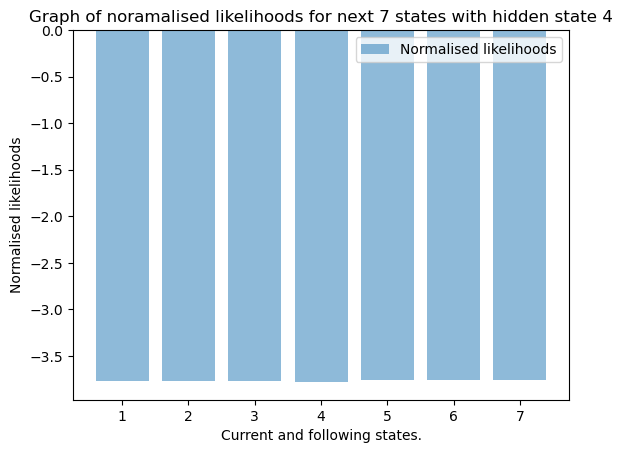

In [10]:
 # Trying by processing methods (not normalisation)

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[36], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[36], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
# print("data dfit values: ",np.mean(probs_data_fit), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
# plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 4")
plt.show()



probs = np.sign(probs) * np.abs(probs)**0.05
probs_data_fit =np.sign(probs_data_fit) * np.abs(probs_data_fit)**0.05
# plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 4")
plt.legend()
print(probs)

data dfit values:  -11847000455499.592 7.321963484593134e+26 77381062649962.23
whole lml values:  -11847000452174.963 7.321963484539912e+26 77381062649600.92


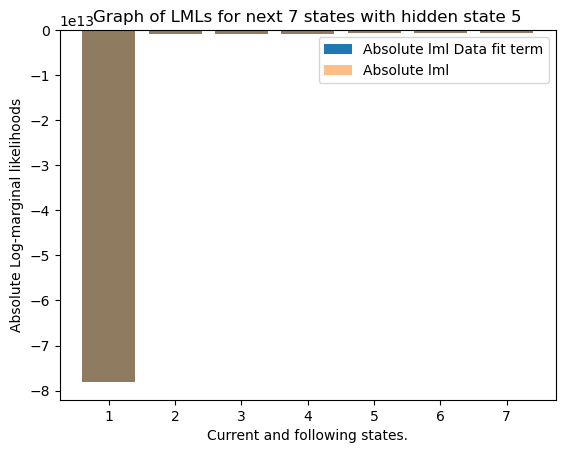

[0.38980617 0.98890981 0.99052378 0.98984777 0.99103488 0.99103488
 0.99103488]


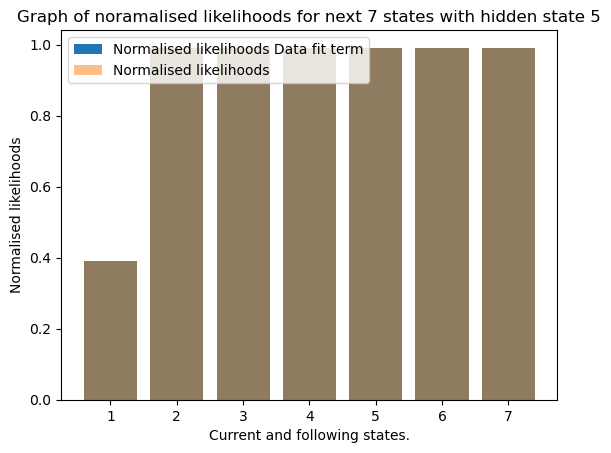

In [11]:
 # Trying by normalisation

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[2], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[2], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
print("data dfit values: ",np.mean(probs_data_fit), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 5")

plt.show()
probs = np.exp(np.array(probs)/np.sum(np.abs(probs)))
probs_data_fit = np.exp(np.array(probs_data_fit)/np.sum(np.abs(probs_data_fit)))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 5")
plt.legend()
print(probs)

In [12]:
lis = np.array([1,2,-3,1])
print(lis**2)


[1 4 9 1]


In [33]:
def viterbi(y: List[np.ndarray], states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = len(states) # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 6
    chunk = 0
    step = w //3
    counter = []
    conversion_rate = sample_rate/hop_length # TODO need to make this more general... may eit should depend on the MIDI suggestion...?
    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)
    scale_factor = 0.05
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
    gamma[0, 0] = lml_scaled

    advance_transition = np.log(0.5)
    self_transition = np.log(0.5)

    # Iterate through observations
    for i in range(1, n):

        # sum_squared = np.sum(np.array(y[i], dtype=np.int64)**2)/len(y)
        # print("sum", sum_squared)

        
        probs = []

        # Calculate transition probabilities TODO this is way too small relatively
        expected = conversion_rate * time_to_next[max_s]/1000
        p = 1 / expected # probability 
        q = 1 - p
        advance_transition = np.sum([q**z * p for z in range(d)])
        self_transition = np.log(1 - advance_transition)
        advance_transition = np.log(advance_transition)

        k0_index = chunk * step
        for k in range(k0_index, k0_index + w):

            lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
            probs.append(lml_scaled)

            same_state = lml + gamma[k,i-1] + self_transition
            advance_state = lml + gamma[k-1, i-1] +  advance_transition

            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1
        
        
        
        new_s = np.argmax(gamma[:,i])

        if new_s == max_s:
            d += 1 # increment count 
        else:
            counter.append(d)
            conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
            conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
            d = 1

        max_s = new_s

        path.append(max_s)

        if max_s >= k0_index + w - step:
            chunk += 1
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path,counter


path, optimal, counter = viterbi(audio_data[:90],  score[:90], cov_dict=cov_dict )
print(path, optimal)

    

[0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 3, 2, 2] [0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [14]:
print(score)

[[262], [262, 330], [262, 330, 392], [523, 262, 330, 392], [330, 523, 659, 262, 392], [330, 523, 392, 659, 262], [330, 523, 392, 659, 262], [330, 523, 659, 392, 262], [330, 523, 659, 392, 262], [523, 659, 392, 262, 330], [523, 659, 392, 262, 330], [659, 523, 392, 262, 330], [659, 523, 392, 262, 330], [392, 659, 523, 262, 330], [392, 659, 523, 262, 330], [659, 392, 523, 262, 330], [392, 659, 523, 262], [523, 659, 294, 262], [262, 659, 440, 294], [659, 440, 294, 262, 587], [440, 294, 698, 262, 587], [294, 698, 262, 440, 587], [587, 294, 698, 262, 440], [587, 294, 262, 440, 698], [587, 294, 262, 440, 698], [587, 294, 262, 440, 698], [587, 294, 440, 262, 698], [587, 294, 440, 262, 698], [587, 294, 440, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 247, 698], [698, 294, 247, 587], [392, 587, 294, 247, 698], [392, 294, 247, 587, 698], [392, 698, 294, 247, 587], [698, 294, 247, 392, 587], [698, 294, 247, 392, 587], [294, 247, 698, 

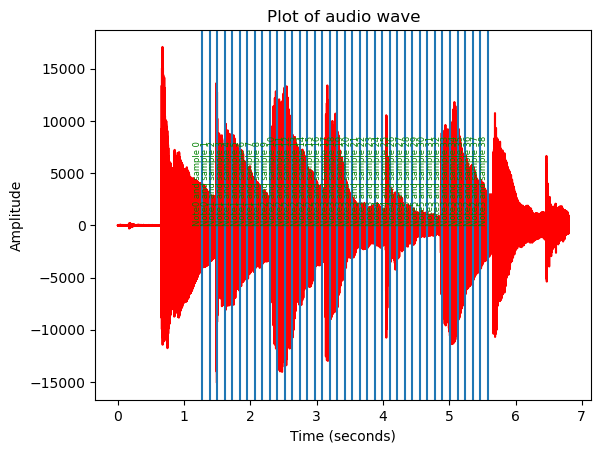

In [34]:
time_samples = np.linspace(0, performance_duration, len(data))
show = 300000
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:39]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]} and sample {_}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

In [16]:
print(score[:8])
score[3] = [262, 330, 392, 523]

[[262], [262, 330], [262, 330, 392], [523, 262, 330, 392], [330, 523, 659, 262, 392], [330, 523, 392, 659, 262], [330, 523, 392, 659, 262], [330, 523, 659, 392, 262]]


In [17]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=100
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:10]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

[-1.92080791 -1.9208076  -1.91954526 -1.91988365 -1.92008565 -1.92008565
 -1.92008565 -1.92008565]


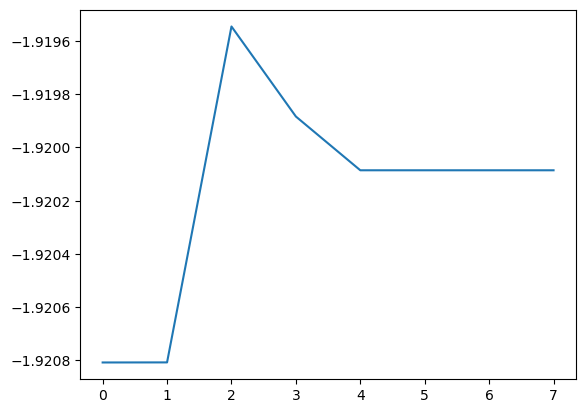

In [18]:
lml = []
for i in range(8):
    lml.append(-helper.stable_nlml(time_samples, audio_data[9], M=9, normalised=False, f=score[i], T=0.465, v=2.37, cov_dict=cov_dict)  )
# lml.append(-helper.relative_nlml(time_samples, audio_data[0], M=9, normalised=False, f=score[1], T=0.465, v=2.37, cov_dict=cov_dict)  )



lml_scaled = np.sign(lml) * np.abs(lml)**0.05
print(lml_scaled)
plt.plot(lml_scaled)

In [19]:
lml.append(-helper.stable_nlml(time_samples, audio_data[20], M=9, normalised=False, f=score[5], T=0.465, v=2.37, cov_dict=cov_dict, amplitude=[])  )

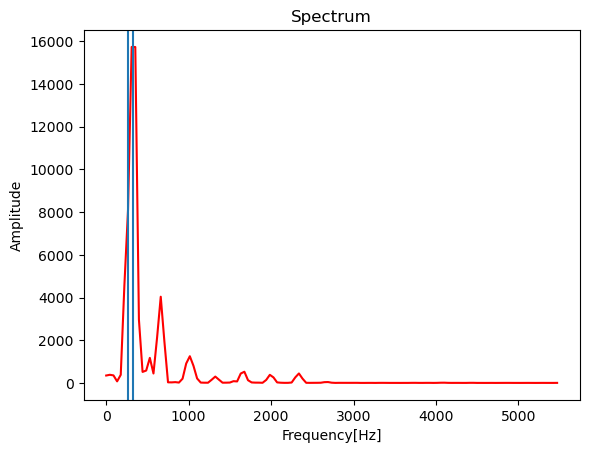

In [20]:
helper.plot_fft(audio_data[5])
plt.axvline(262)
plt.axvline(330)


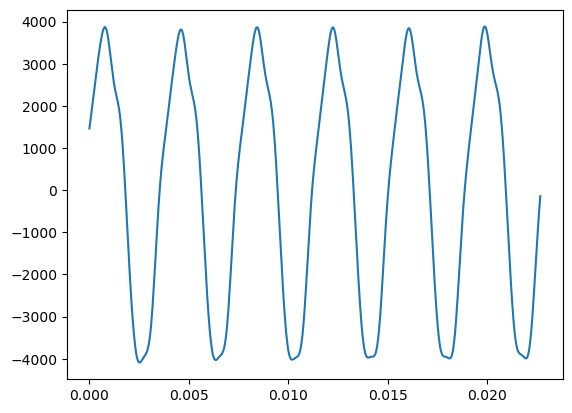

In [21]:
time_samples = np.linspace(0, len(audio_data[0])/sample_rate, sample_length)
plt.plot(time_samples,audio_data[0])

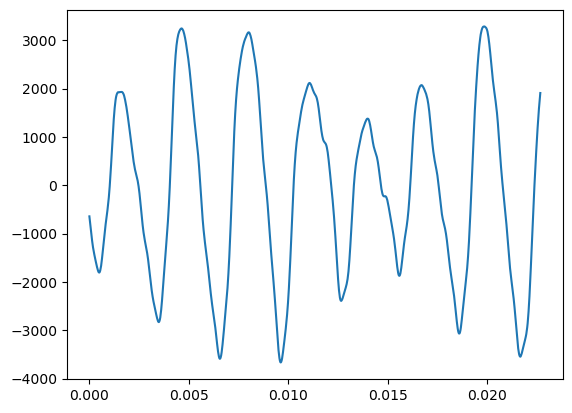

In [22]:
plt.plot(time_samples,audio_data[5])

In [23]:
import socket
import time
backend_output: str = "udp:127.0.0.1:4000"
reduced_backend_output = backend_output[4:]
# try to parse UDP IP and port
address_port = reduced_backend_output.split(":")
if len(address_port) != 2:
    raise ValueError(
        f"Unknown `backend_output`: {backend_output}")
addr = str(address_port[0])
port = int(address_port[1])

socket1 = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
print(
    f"Backend will be outputting via UDP to {addr}:{port}")
for i in range(100):
    socket1.sendto(str(i).encode(), (addr, port))
    print(i, flush=True)
    time.sleep(0.1)

Backend will be outputting via UDP to 127.0.0.1:4000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
